ДЗ - в рамках ранее выполненной работы по обработке данных, выполнить все работы 
с пандас дата фреймом через SQL запросы. 
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)

credit_train.csv

In [27]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
import pandasql as ps

sqlite3.sqlite_version
con = sqlite3.connect('db1') #соединяемся с виртуальной базой db 

with open('credit_train.csv', newline='', encoding='Windows-1251') as f:
    # Открываем исходный файл. Т.к он разделен точками с запятой сначала
    #убираем запятые, меняем их на точки, потом заменяем точки с запятой на запятые.    
    str = f.read().replace(",", "." ) 
    str = str.replace(";",",")
    # Создаем файл с разделением запятыми для нормального открытия питоном:
    with open('train_ready.csv','w',  encoding='Windows-1251') as file2:    
        file2.write(str)
        
# Создаем усеченный датафрейм для дальнейшей обработки. Удаляем пропуски:
df = pd.read_csv("train_ready.csv",encoding='Windows-1251' ,on_bad_lines='skip',
                    #index_col='client_id' ,
                    usecols=[0,1,2,3,4, 5,6,7,8,9,10,11,13,14]
                    )
#df = df.dropna()
df.to_sql('credit_train',con, index = True,if_exists = 'replace')


#df = pd.read_csv('credit_train.csv',encoding='Windows-1251') # откроем тестовый файл

170746

 Разобъем данные на тестовую и тренеровочную выборки:# 

In [28]:
df_test,df_train = train_test_split(df, test_size=0.1, train_size=0.9)
print('длина тестовой выборки:  ',len(df_test),',  длина тренировочной выборки:  ',len(df_train))

длина тестовой выборки:   153671 ,  длина тренировочной выборки:   17075


In [29]:
# Удаление данных с пропусками!
sql2 = ''' delete FROM credit_train where   
marital_status  IS NULL 
or age IS NULL  
or credit_sum IS NULL  
or score_shk IS NULL  
or education IS NULL 
or credit_month IS NULL 
or job_position IS NULL 
'''
con.execute(sql2)
sql3 = ''' select * FROM credit_train '''
df_no_nan = pd.read_sql_query(sql3,con)
# df_no_nan  - полный датасет без пропусков данных.
print(len(df_no_nan))

170736


Было 170745, стало 170736. Удалилось 10 записей с пропусками.
Также в ходе выполнения мы увидели, что база данных Credit_train изменяется отдельно, а датафрейм df остается нетронутым!!!

Оценим выбросы. Для этого сначала добавим колонку по столбцу credit_sum, в которой содержится количество чисел zscores

In [31]:
# получение датасета с значениями zscores вместо credit_sum:
from scipy import stats
sql2 = "select credit_sum as zscores from credit_train   "
df_credit = pd.read_sql(sql2,con)
#print(df_credit)
zscores = (stats.zscore(df_credit, axis=0, nan_policy='omit'))
col_zscores = zscores['zscores']

print (len(zscores))
print (len(df_no_nan))
# Добавляем столбик zscores в общую таблицу.
df_no_nan = pd.concat([df_no_nan,col_zscores],axis = 1)
print(df_no_nan)
# Создаем еще одну таблицу базы данных для того, чтобы в дальнейшем удалить выбросы запросом 

df_no_nan.to_sql('credit_train_zscores',con, index = True,if_exists = 'replace')

# Выберем данные, которые являются выбросами:
sql4 = "select client_id,credit_sum from credit_train_zscores where zscores>3 or zscores<-3  "
df_outliers = pd.read_sql(sql4,con)
print(" количество строк, не укладывающихся в нормальное распределение:  ",len(df_outliers))

170736
170736
         index  client_id gender   age marital_status job_position  \
0            7          8      F  26.0            UNM          SPC   
1            9         10      F  32.0            UNM          SPC   
2           10         11      M  26.0            MAR          SPC   
3           12         13      M  37.0            MAR          SPC   
4           13         14      M  43.0            MAR          INP   
...        ...        ...    ...   ...            ...          ...   
170731  170741     170742      F  27.0            UNM          SPC   
170732  170742     170743      F  24.0            MAR          SPC   
170733  170743     170744      F  31.0            UNM          SPC   
170734  170744     170745      F  53.0            DIV          PNA   
170735  170745     170746      M  49.0            MAR          SPC   

        credit_sum  credit_month  tariff_id  score_shk education  \
0         47878.00            10       1.10   0.512525       GRD   
1        

Удалим выбросы, их 1834 строки:

In [32]:
sql5 = "delete from credit_train_zscores where zscores>3 or zscores<-3  "
con.execute(sql5)
sql6 = "select count(*) from credit_train_zscores "
print("количество строк без выбросов: ", pd.read_sql(sql6,con))

количество строк без выбросов:     count(*)
0    168902


Данные удалились, количество строк уменьшилось.

Далее построим гистограммы данных по столбику credit_sum до удаления и после удаления.
До удаления:

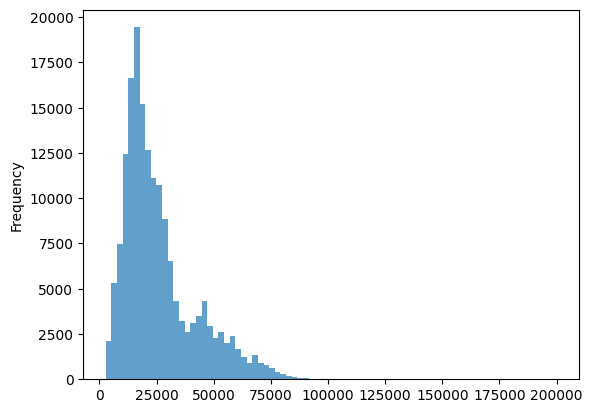

In [33]:
ax = df['credit_sum'].plot.hist(bins=80, alpha=0.7)

После удаления:

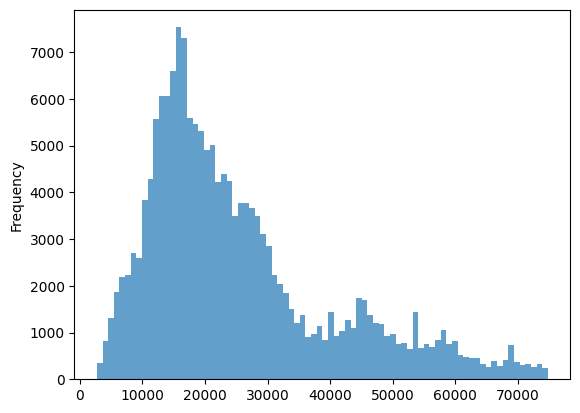

In [34]:
sql7 = "select credit_sum from credit_train_zscores "
df7 = pd.read_sql(sql7,con)
ax = df7['credit_sum'].plot.hist(bins=80, alpha=0.7)

Мы видим как выровнялась гистограмма после удаления выбросов.

Создадим поле, в котором найдем соотношение суммы кредита к заработной плате. Отсортируем по нему, найдя самых 
отчаянных кредитополучателей. Если рискованность более 5 выведем 1, иначе 0

In [35]:
sql8 = '''    select credit_sum, monthly_income, credit_sum/monthly_income as risky_coeff, case when credit_sum/monthly_income>5  then 1 else 0 end as risky_index from credit_train order by risky_coeff'''
df7 = pd.read_sql(sql8,con)
print(df7)


        credit_sum  monthly_income  risky_coeff  risky_index
0          13009.0             NaN          NaN            0
1           3520.0        300000.0     0.011733            0
2           5841.0        400000.0     0.014602            0
3           5841.0        400000.0     0.014602            0
4          11398.0        680000.0     0.016762            0
...            ...             ...          ...          ...
170731     90400.0         10000.0     9.040000            1
170732    139989.0         15000.0     9.332600            1
170733    200000.0         20000.0    10.000000            1
170734     80010.0          5000.0    16.002000            1
170735    169000.0         10000.0    16.900000            1

[170736 rows x 4 columns]


Выводы:  SQL запросы хороши для манипуляции данными и для достаточно простых математических операций.
Также ими удобно объединять и работать данными из нескольких таблиц, т.е использовать реляционную модель.

Главная проблема - сложно заполнить столбик таблицы данными из массива, датафрейма и тд. Потому что SQL запрос
принимает только данные из таблиц. Т. е сначала надо создавать таблицу, содержащую в себе нужный столбец данных, и 
только потом эти данные можно скопировать в нужное место SQL запросом.

Если же нужны более сложные операции типа анализа на нормальность, корреляции, обработки выбросов, то здесь необходимо использовать датафреймы.